# NASA Spectrograms

In [23]:
import os
import numpy as np
import scipy.io
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Change input and output folders as necessary:

In [34]:
# Root folder for NASA experiment folders
NASA_root_folder = r"C:\Users\simon\Downloads\archive"

# Desired output folder
NASA_spectrogram_output_folder_path = r"C:\Users\simon\Documents\datasets\NASA\processed_spectrograms"

Do not change unless NASA subfolder structure is different:

In [25]:
# NASA experiment subfolders
NASA_experiment_paths = [
    r"1st_test\1st_test",
    r"2nd_test\2nd_test",
    r"3rd_test\4th_test\txt"
]

# Channels with bearing faults for each NASA subfolder
NASA_bearing_channels = [
    [4, 6],
    [0],
    [2]
]

# Generate full paths from root folder and subfolders
NASA_experiment_full_paths = [os.path.join(NASA_root_folder, NASA_experiment_path) for NASA_experiment_path in NASA_experiment_paths]

# Ensure the output directory exists
if not os.path.exists(NASA_spectrogram_output_folder_path):
    os.makedirs(NASA_spectrogram_output_folder_path)

Functions to generate spectrograms and save them as .mat-files:

In [29]:
def generate_combined_spectrogram(folder_path, channel_index):
    """Combines Fourier Transforms from all files for a specific channel into a single spectrogram."""
    file_names = sorted(os.listdir(folder_path), key=lambda x: datetime.strptime(x, "%Y.%m.%d.%H.%M.%S"))
    spectrogram = []
    timestamps = []

    for file_name in tqdm(file_names, desc=f"Processing files for channel {channel_index}"):
        full_path = os.path.join(folder_path, file_name)
        data = np.loadtxt(full_path)
        
        # Perform Fourier Transform on the selected channel's data
        fft_result = np.fft.fft(data[:, channel_index])
        spectrogram.append(np.abs(fft_result))
        
        # Store timestamp
        timestamps.append(datetime.strptime(file_name, "%Y.%m.%d.%H.%M.%S").timestamp())

    # Normalize and convert to dB scale
    spectrogram = np.array(spectrogram).T
    spectrogram_max = spectrogram.max()
    if spectrogram_max != 0:
        spectrogram = spectrogram / spectrogram_max

    # Convert to decibels
    spectrogram_dB = 20 * np.log10(spectrogram + 1e-6)

    # Remove redundant (mirrored) data
    spectrogram_dB = spectrogram_dB[:spectrogram_dB.shape[0]//2, :]

    return spectrogram_dB, timestamps

def save_to_mat_file(output_path, filename, spectrogram, timestamps):
    """Saves the spectrogram and timestamps to a .mat file."""
    full_output_path = os.path.join(output_path, filename)
    scipy.io.savemat(full_output_path, {'spectrogram': spectrogram, 'timestamps': timestamps})


Generate spectrograms and save to output folder:

In [ ]:
# Generate and save spectrograms as .mat-files for each relevant channel in each NASA experiment
for i, NASA_experiment_full_path in enumerate(NASA_experiment_full_paths):
    for channel_index in NASA_bearing_channels[i]:
        spectrogram, timestamps = generate_combined_spectrogram(NASA_experiment_full_path, channel_index)
        spectrogram_output_file_path = os.path.join(NASA_spectrogram_output_folder_path, f"{i+1}_channel_{channel_index}.mat")
        save_to_mat_file(NASA_spectrogram_output_folder_path, spectrogram_output_file_path, spectrogram, timestamps)

Load, plot, and save spectrograms as images (optional):

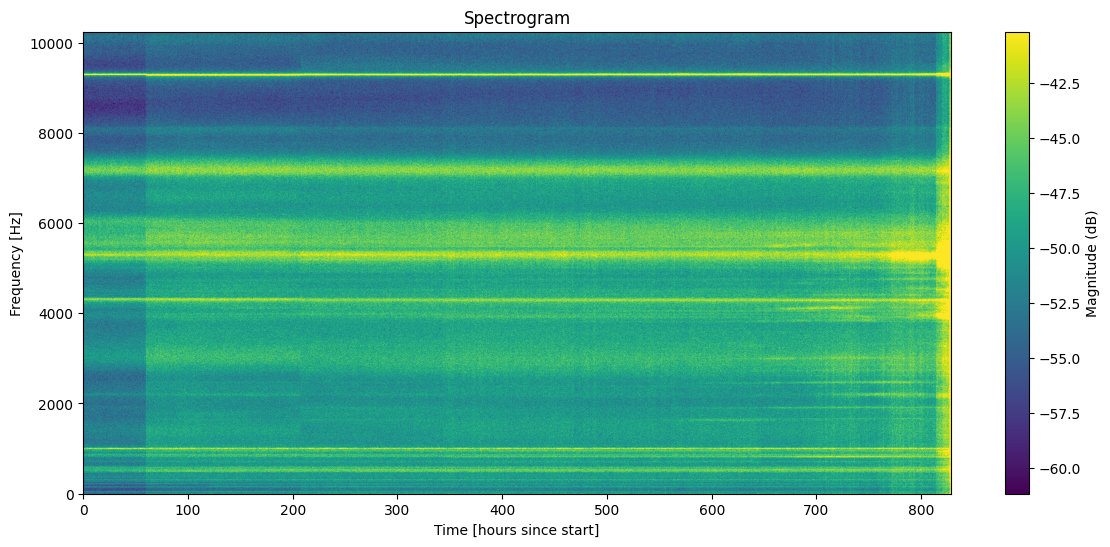

In [32]:
def load_mat_and_plot_spectrogram(mat_file_path, save_filename=None):
    # Load data from .mat file
    mat_data = scipy.io.loadmat(mat_file_path)
    spectrogram = mat_data['spectrogram']
    timestamps = mat_data['timestamps'][0]  # Assuming timestamps is a 1D array

    # Convert timestamps to a more readable format (e.g., hours since start)
    start_time = timestamps[0]
    time_hours = (timestamps - start_time) / 3600  # Convert seconds to hours

    # Plot the spectrogram with adjusted color limits and a different colormap
    plt.figure(figsize=(14, 6))
    norm = colors.Normalize(vmin=np.percentile(spectrogram, 5), vmax=np.percentile(spectrogram, 95))  # Normalize the color range
    plt.imshow(spectrogram, aspect='auto', origin='lower', 
               extent=[time_hours[0], time_hours[-1], 0, spectrogram.shape[0]],
               cmap='viridis', norm=norm)  # Use 'inferno' colormap for better contrast
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time [hours since start]')
    plt.ylabel('Frequency [Hz]')
    plt.title('Spectrogram')
    if save_filename is not None:
        plt.savefig(save_filename)
    plt.show()


# Example usage
# mat_file_path = r"C:\Users\simon\Documents\datasets\NASA\processed_spectrograms\experiment_1_channel_6.mat"
# load_mat_and_plot_spectrogram(mat_file_path, "1_6.pdf")